In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv("../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../data/dacon_parking_demand_dataset/test.csv")
age = pd.read_csv("../../data/dacon_parking_demand_dataset/age_gender_info.csv")
rent_deposit = pd.read_csv("predicted_rent_deposit.csv")

In [3]:
train.shape, test.shape, rent_deposit.shape

((2952, 15), (1022, 14), (767, 2))

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 지역별 평균 값으로 치환
train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [15]:
train_df.index

Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
            ...
            2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951],
           dtype='int64', length=2869)

In [16]:
test_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021],
           dtype='int64', length=1008)

In [17]:
train_df[train_df["임대보증금"] == 0].index

Int64Index([  88,   89,   90,   91,  101,  102,  103,  104,  105,  106,
            ...
            2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907, 2908],
           dtype='int64', length=581)

In [18]:
test_df[test_df["임대보증금"] == 0].index

Int64Index([  76,   77,   79,   80,   81,   82,   83,   84,   85,   86,
            ...
             329,  330,  331,  332, 1005, 1006, 1014, 1015, 1016, 1017],
           dtype='int64', length=186)

In [19]:
rent_deposit.iloc[581]

index          76.0
임대보증금    11258525.0
Name: 581, dtype: float64

In [20]:
train_rent_deposit = rent_deposit.iloc[:581]
test_rent_deposit = rent_deposit.iloc[581:]

In [21]:
train_rent_deposit = train_rent_deposit.set_index("index")
test_rent_deposit = test_rent_deposit.set_index("index")

In [22]:
train_df.loc[train_rent_deposit.index, "임대보증금"] = train_rent_deposit["임대보증금"]
test_df.loc[test_rent_deposit.index, "임대보증금"] = test_rent_deposit["임대보증금"]

In [23]:
train_df[train_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [24]:
test_df[test_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


In [25]:
train_df["임대보증금"].isnull().sum()

0

In [26]:
test_df["임대보증금"].isnull().sum()

0

<AxesSubplot:>

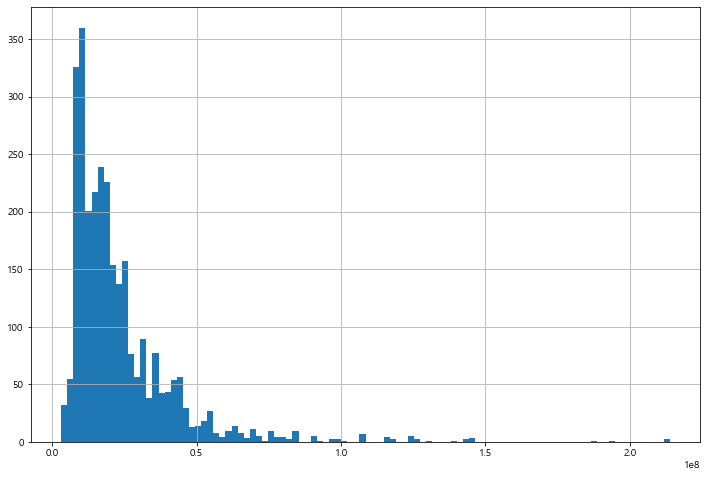

In [27]:
train_df["임대보증금"].hist(bins=100, figsize=(12, 8))

In [28]:
train_df["임대보증금"].value_counts()

24775000.0    22
14418000.0    21
9364600.0     20
5787000.0     18
18726000.0    17
              ..
10164325.0     1
10286050.0     1
13155000.0     1
8625000.0      1
22043000.0     1
Name: 임대보증금, Length: 1098, dtype: int64

In [29]:
train_df["임대보증금"].skew()

3.36460878202262

In [30]:
train_df["임대보증금"].kurt()

18.758347504146197

In [31]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [32]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [33]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [34]:
train_df.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', '실거주세대수'],
      dtype='object')

In [35]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["총세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["총세대수"]) * test_df["단지내주차면수"]

In [36]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [37]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

<AxesSubplot:>

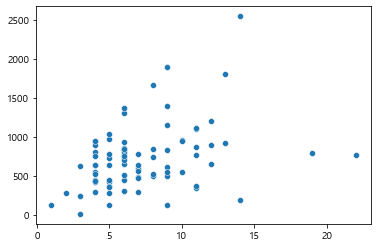

In [38]:
area_group = train_df.groupby("지역")["등록차량수"]

values = area_group.get_group("경기도").value_counts().index
counts = area_group.get_group("경기도").value_counts().values

sns.scatterplot(x=counts, y=values)

In [39]:
# 지역별 인구수 컬럼 추가

# population_df = pd.read_csv("../data/dacon_parking_demand_dataset/age_gender_info.csv")
# partial_population_df = population_df[["20대(남자)", "40대(남자)", "50대(여자)", "지역"]]
# train_df = pd.merge(train_df, partial_population_df, on="지역")
# test_df = pd.merge(test_df, partial_population_df, on="지역")

# train_df.columns

In [40]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [41]:
train_df[train_df["단지코드"] == "C1039"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000.0,...,0,0,0,0,0,0,0,0,0,0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000.0,...,0,0,0,0,0,0,0,0,0,0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [43]:
# 전용 면적 피처를 5의 배수로 전처리, 전후로 비교해서 (103.69 -> 102.80까지 떨어짐)
train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [44]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [45]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [46]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [47]:
train_df["공급유형"].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공임대(분납)        7
공공분양            7
공공임대(5년)        3
장기전세            3
Name: 공급유형, dtype: int64

In [48]:
train_df[train_df["공급유형"] == "장기전세"]

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적,전용면적 당 차량등록수
2100,C1039,790,서울특별시,장기전세,50.0,126,13.0,A,187694000.0,-,...,0,0,0,0,0,0,1,6300.0,33080.0,122.838573
2101,C1039,790,서울특별시,장기전세,55.0,49,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,2695.0,33080.0,52.547612
2102,C1039,790,서울특별시,장기전세,55.0,75,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,4125.0,33080.0,80.430018


In [49]:
test_df["공급유형"].value_counts() # 테스트 셋에는 없는 공급유형 -> 공공분양, 공공임대(5년), 장기전세

국민임대         614
임대상가         177
행복주택         120
영구임대          43
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [50]:
supply_qualification_df = pd.get_dummies(train_df["공급유형"])
train_df = pd.concat([train_df, supply_qualification_df], axis=1)

supply_qualification_df = pd.get_dummies(test_df["공급유형"])
test_df = pd.concat([test_df, supply_qualification_df], axis=1)
test_df["공공임대(5년)"] = 0
test_df["공공분양"] = 0
test_df["장기전세"] = 0

In [51]:
train_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적', '전용면적 당 차량등록수', '공공분양', '공공임대(10년)', '공공임대(50년)',
       '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [52]:
test_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'B', 'F', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적',
       '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택',
       '공공임대(5년)', '공공분양', '장기전세'],
      dtype='object')

In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 전처리한 피처들의 선형성 검증 이변량 분석

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

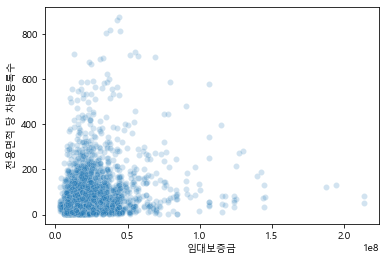

In [54]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

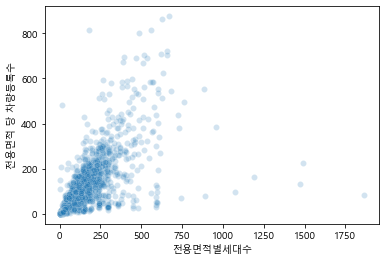

In [55]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [56]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [57]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [58]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

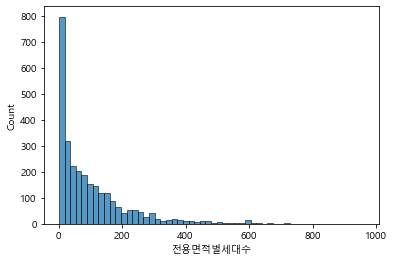

In [59]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

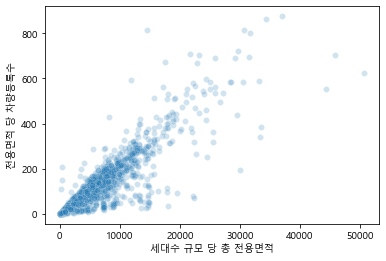

In [60]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [61]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

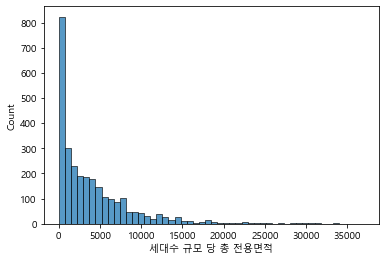

In [62]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='실거주세대수', ylabel='전용면적 당 차량등록수'>

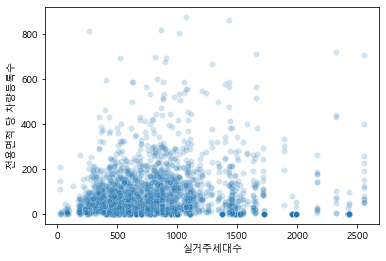

In [63]:
sns.scatterplot(data=train_df, x="실거주세대수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='실거주세대수', ylabel='Count'>

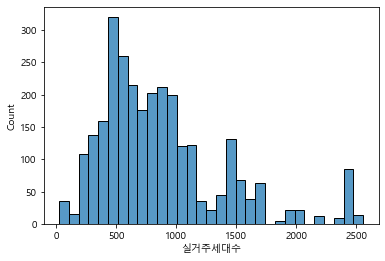

In [64]:
sns.histplot(train_df["실거주세대수"])

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='전용면적 당 차량등록수'>

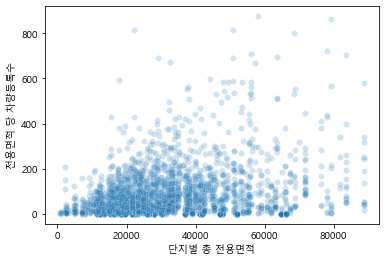

In [65]:
sns.scatterplot(data=train_df, x="단지별 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='단지별 총 전용면적', ylabel='Count'>

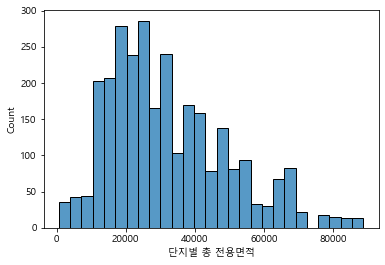

In [66]:
sns.histplot(train_df["단지별 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

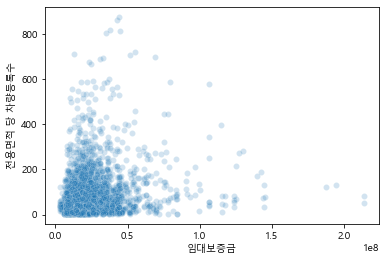

In [67]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [68]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='전용면적 당 차량등록수'>

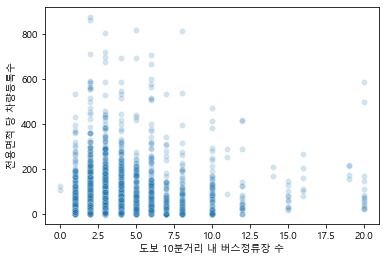

In [69]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 버스정류장 수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 버스정류장 수', ylabel='Count'>

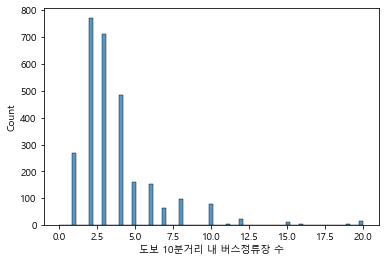

In [70]:
sns.histplot(train_df["도보 10분거리 내 버스정류장 수"])

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='전용면적 당 차량등록수'>

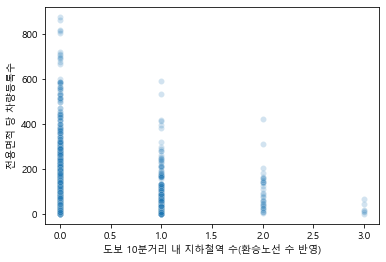

In [71]:
sns.scatterplot(data=train_df, x="도보 10분거리 내 지하철역 수(환승노선 수 반영)", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='도보 10분거리 내 지하철역 수(환승노선 수 반영)', ylabel='Count'>

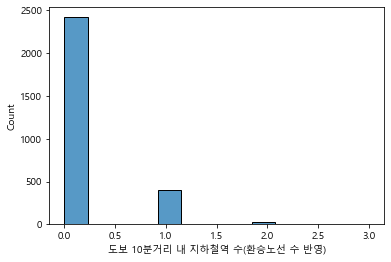

In [72]:
sns.histplot(train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"])

<AxesSubplot:xlabel='상가', ylabel='전용면적 당 차량등록수'>

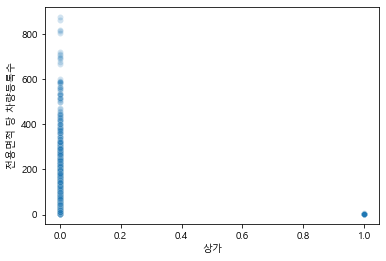

In [73]:
sns.scatterplot(data=train_df, x="상가", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

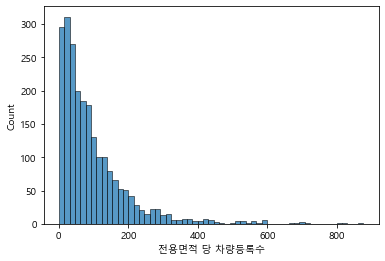

In [74]:
sns.histplot(train_df[train_df["상가"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

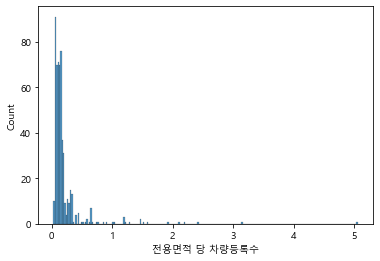

In [75]:
sns.histplot(train_df[train_df["상가"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

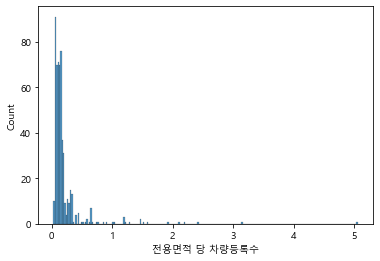

In [76]:
sns.histplot(train_df[train_df["아파트"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

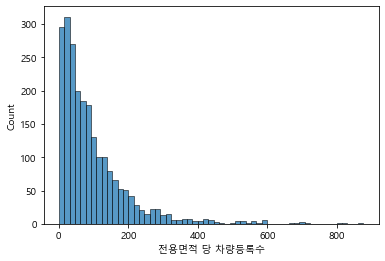

In [77]:
sns.histplot(train_df[train_df["아파트"] == 1]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='전용면적 당 차량등록수', ylabel='Count'>

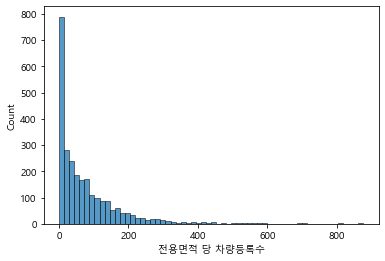

In [78]:
sns.histplot(train_df[train_df["강원도"] == 0]["전용면적 당 차량등록수"])

<AxesSubplot:xlabel='자격유형', ylabel='전용면적 당 차량등록수'>

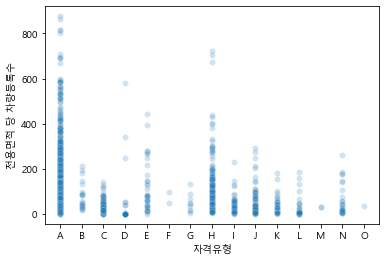

In [79]:
sns.scatterplot(data=train_df, x="자격유형", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='지역', ylabel='전용면적 당 차량등록수'>

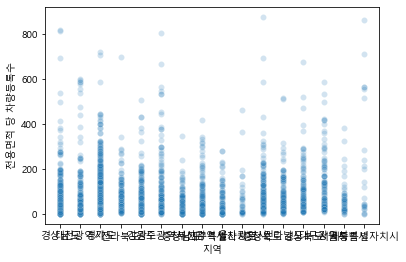

In [80]:
sns.scatterplot(data=train_df, x="지역", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

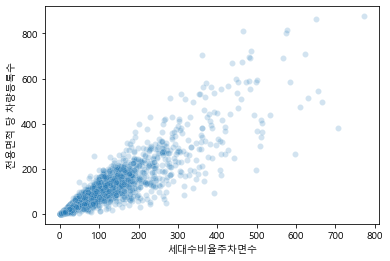

In [81]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [82]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [83]:
correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

# plt.figure(figsize=(20, 16))
# sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [84]:
correlation_df

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,A,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
전용면적 당 차량등록수,-0.008533,0.086054,0.789069,0.121870,0.242554,-0.084184,0.070765,0.384005,0.493973,0.332329,...,0.053883,0.266957,0.017333,0.066608,0.022382,0.250349,-0.088255,-0.375536,NaN,-0.096768
세대수비율주차면수,0.030998,0.022091,0.899726,0.231008,0.157354,-0.083603,0.064925,0.445262,0.418512,0.311208,...,0.018249,0.167366,0.014993,0.057257,0.012663,0.297280,-0.049113,-0.408158,NaN,-0.066137
세대수 규모 당 총 전용면적,0.016870,0.068713,0.925335,0.141603,0.183507,-0.076317,0.072934,0.344077,0.367491,0.302032,...,0.034181,0.203279,0.075896,0.012340,0.010665,0.232106,0.062740,-0.402512,NaN,-0.101567
전용면적별세대수,0.062013,-0.030675,1.000000,0.185720,0.054522,-0.075917,0.064737,0.323313,0.296089,0.195018,...,0.000841,0.054284,0.087283,0.009768,-0.007566,0.218229,0.195092,-0.410776,NaN,-0.032354
등록차량수,0.327042,0.096542,0.296089,0.129783,0.421823,-0.077352,0.111463,0.857204,1.000000,0.346411,...,0.203075,0.390067,-0.059064,0.025368,0.084339,0.263739,-0.089065,-0.449912,NaN,-0.125648
단지내주차면수,0.521607,0.052993,0.323313,0.302376,0.356830,-0.026177,0.079991,1.000000,0.857204,0.263348,...,0.132360,0.230656,-0.075575,0.014964,0.047712,0.288324,-0.083749,-0.409617,NaN,-0.063084
아파트,-0.345064,-0.015352,0.410776,0.249805,0.330165,-0.158689,0.013776,0.409617,0.449912,0.610290,...,0.024554,0.125399,0.051037,0.016063,0.024554,0.611632,0.115392,-1.000000,NaN,0.136663
A,-0.339916,0.118514,0.195018,0.007473,0.122621,-0.096454,0.011556,0.263348,0.346411,1.000000,...,-0.061113,0.205475,0.083628,0.026320,0.040233,0.684438,-0.280724,-0.610290,NaN,-0.340145
공공임대(10년),-0.032233,0.188488,0.054284,-0.066621,0.390556,-0.048931,0.001646,0.230656,0.390067,0.205475,...,-0.012557,1.000000,-0.026101,-0.008215,-0.012557,-0.312798,-0.059013,-0.125399,NaN,-0.069891
국민임대,-0.255778,0.007655,0.218229,0.144856,0.028774,-0.099070,0.018739,0.288324,0.263739,0.684438,...,-0.061247,-0.312798,-0.127309,-0.040067,-0.061247,1.000000,-0.287835,-0.611632,NaN,-0.340893


In [85]:
# X_train & X_test 셋 선택

# ["상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
#  "전용면적 당 차량등록수", "총세대수"]

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [86]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [87]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [88]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
8,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2948,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2949,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2950,114,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [89]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression 모델 평가

In [90]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor


In [91]:
X_train_df_log.shape, X_test_df_log.shape, y_train_df_log.shape

((2854, 48), (1008, 48), (2854,))

In [92]:
params = {"alpha": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
ridge_model = Ridge()

grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1,
                                   1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40,
                                   50]},
             scoring='neg_mean_absolute_error')

In [93]:
grid_model.best_params_

{'alpha': 40}

In [94]:
best_ridge = grid_model.best_estimator_
best_ridge

Ridge(alpha=40)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = best_ridge.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.872570330798702

In [96]:
# # 릿지 모델 예측

# ridge_model = Ridge(alpha=30)
# ridge_model.fit(X_train_df_log, y_train_df_log)
# pred = ridge_model.predict(X_test_df_log)
# pred = np.expm1(pred)

# result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
# result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

# pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
# final_pred = pd.Series(pred_group)
# final_pred = final_pred.reset_index(drop=False)

# sub_df = sub.merge(final_pred, how="left")
# sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
# sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
# sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# # sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

# sub_df

In [97]:
# importance = ridge_model.coef_
# feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(20, 12))
# sns.barplot(x=feature_importance, y=feature_importance.index)
# plt.show()

In [98]:
cat_reg = CatBoostRegressor()

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7666332	total: 151ms	remaining: 2m 31s
1:	learn: 1.6949319	total: 153ms	remaining: 1m 16s
2:	learn: 1.6280416	total: 154ms	remaining: 51.2s
3:	learn: 1.5616178	total: 155ms	remaining: 38.7s
4:	learn: 1.5005406	total: 156ms	remaining: 31.1s
5:	learn: 1.4392506	total: 157ms	remaining: 26.1s
6:	learn: 1.3816570	total: 159ms	remaining: 22.5s
7:	learn: 1.3272545	total: 160ms	remaining: 19.8s
8:	learn: 1.2734685	total: 161ms	remaining: 17.7s
9:	learn: 1.2239547	total: 162ms	remaining: 16.1s
10:	learn: 1.1779871	total: 163ms	remaining: 14.7s
11:	learn: 1.1325531	total: 165ms	remaining: 13.6s
12:	learn: 1.0891602	total: 166ms	remaining: 12.6s
13:	learn: 1.0486372	total: 167ms	remaining: 11.8s
14:	learn: 1.0097830	total: 168ms	remaining: 11s
15:	learn: 0.9710438	total: 169ms	remaining: 10.4s
16:	learn: 0.9353350	total: 170ms	remaining: 9.83s
17:	learn: 0.9004024	total: 171ms	remaining: 9.34s
18:	learn: 0.8689133	total: 173ms	remaining: 8.91s
19:	learn: 0

296:	learn: 0.1783609	total: 515ms	remaining: 1.22s
297:	learn: 0.1783183	total: 516ms	remaining: 1.22s
298:	learn: 0.1780406	total: 517ms	remaining: 1.21s
299:	learn: 0.1777951	total: 518ms	remaining: 1.21s
300:	learn: 0.1774531	total: 520ms	remaining: 1.21s
301:	learn: 0.1770817	total: 521ms	remaining: 1.2s
302:	learn: 0.1768774	total: 522ms	remaining: 1.2s
303:	learn: 0.1767639	total: 524ms	remaining: 1.2s
304:	learn: 0.1764479	total: 525ms	remaining: 1.2s
305:	learn: 0.1764098	total: 526ms	remaining: 1.19s
306:	learn: 0.1763475	total: 527ms	remaining: 1.19s
307:	learn: 0.1760627	total: 528ms	remaining: 1.19s
308:	learn: 0.1759547	total: 530ms	remaining: 1.18s
309:	learn: 0.1759241	total: 531ms	remaining: 1.18s
310:	learn: 0.1756583	total: 532ms	remaining: 1.18s
311:	learn: 0.1754546	total: 534ms	remaining: 1.18s
312:	learn: 0.1751115	total: 535ms	remaining: 1.17s
313:	learn: 0.1746143	total: 536ms	remaining: 1.17s
314:	learn: 0.1743449	total: 537ms	remaining: 1.17s
315:	learn: 0.17

573:	learn: 0.1340179	total: 851ms	remaining: 631ms
574:	learn: 0.1339191	total: 852ms	remaining: 630ms
575:	learn: 0.1338551	total: 853ms	remaining: 628ms
576:	learn: 0.1337425	total: 854ms	remaining: 626ms
577:	learn: 0.1335937	total: 855ms	remaining: 625ms
578:	learn: 0.1335191	total: 857ms	remaining: 623ms
579:	learn: 0.1334631	total: 858ms	remaining: 621ms
580:	learn: 0.1333139	total: 859ms	remaining: 619ms
581:	learn: 0.1332248	total: 860ms	remaining: 618ms
582:	learn: 0.1331198	total: 861ms	remaining: 616ms
583:	learn: 0.1330398	total: 863ms	remaining: 615ms
584:	learn: 0.1328968	total: 864ms	remaining: 613ms
585:	learn: 0.1328083	total: 865ms	remaining: 611ms
586:	learn: 0.1326728	total: 866ms	remaining: 610ms
587:	learn: 0.1325216	total: 868ms	remaining: 608ms
588:	learn: 0.1323798	total: 869ms	remaining: 606ms
589:	learn: 0.1322618	total: 870ms	remaining: 605ms
590:	learn: 0.1321887	total: 871ms	remaining: 603ms
591:	learn: 0.1320038	total: 873ms	remaining: 601ms
592:	learn: 

855:	learn: 0.1070700	total: 1.19s	remaining: 200ms
856:	learn: 0.1070665	total: 1.19s	remaining: 199ms
857:	learn: 0.1069665	total: 1.19s	remaining: 197ms
858:	learn: 0.1068438	total: 1.19s	remaining: 196ms
859:	learn: 0.1067213	total: 1.19s	remaining: 194ms
860:	learn: 0.1066403	total: 1.2s	remaining: 193ms
861:	learn: 0.1065468	total: 1.2s	remaining: 192ms
862:	learn: 0.1064893	total: 1.2s	remaining: 190ms
863:	learn: 0.1063815	total: 1.2s	remaining: 189ms
864:	learn: 0.1063165	total: 1.2s	remaining: 187ms
865:	learn: 0.1062381	total: 1.2s	remaining: 186ms
866:	learn: 0.1062010	total: 1.2s	remaining: 185ms
867:	learn: 0.1061259	total: 1.2s	remaining: 183ms
868:	learn: 0.1060307	total: 1.21s	remaining: 182ms
869:	learn: 0.1060108	total: 1.21s	remaining: 180ms
870:	learn: 0.1059127	total: 1.21s	remaining: 179ms
871:	learn: 0.1058503	total: 1.21s	remaining: 177ms
872:	learn: 0.1058430	total: 1.21s	remaining: 176ms
873:	learn: 0.1057834	total: 1.21s	remaining: 175ms
874:	learn: 0.105738

9.300786646759335

In [99]:
# 릿지 0.5 & LGBM 0.5 조합 -> 12.3456 Score: 93.5424 (인구데이터 추가)
# 릿지 1.0 -> 14.9751 Score: 95.6543 (인구데이터 X)

# 릿지 0.9 & CatBoost 0.1 조합 -> 14.18295
# 릿지 0.8 & CatBoost 0.2 조합 -> 13.4380
# 릿지 0.7 & CatBoost 0.3 조합 -> 12.7728
# 릿지 0.6 & CatBoost 0.4 조합 -> 12.1470
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6074

# 릿지 alpha=50, 값으로 예측!!! 결과
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6044
# 릿지 0.4 & CatBoost 0.6 조합 -> 11.0139
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.5106

# 릿지 alpha=40,값으로 예측!! 결과
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.4283
# 릿지 0.4 & CatBoost 0.6 조합 -> 10.9511

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7650488	total: 1.73ms	remaining: 1.73s
1:	learn: 1.6931787	total: 3.47ms	remaining: 1.73s
2:	learn: 1.6264025	total: 5ms	remaining: 1.66s
3:	learn: 1.5625792	total: 6.32ms	remaining: 1.57s
4:	learn: 1.4992178	total: 7.52ms	remaining: 1.5s
5:	learn: 1.4389608	total: 8.72ms	remaining: 1.45s
6:	learn: 1.3818035	total: 9.93ms	remaining: 1.41s
7:	learn: 1.3261995	total: 11.1ms	remaining: 1.38s
8:	learn: 1.2749134	total: 12.3ms	remaining: 1.35s
9:	learn: 1.2256489	total: 13.5ms	remaining: 1.33s
10:	learn: 1.1776050	total: 14.7ms	remaining: 1.32s
11:	learn: 1.1347216	total: 15.8ms	remaining: 1.3s
12:	learn: 1.0906181	total: 17ms	remaining: 1.29s
13:	learn: 1.0497745	total: 18.3ms	remaining: 1.29s
14:	learn: 1.0091016	total: 19.5ms	remaining: 1.28s
15:	learn: 0.9701991	total: 20.6ms	remaining: 1.27s
16:	learn: 0.9336692	total: 21.8ms	remaining: 1.26s
17:	learn: 0.8986385	total: 23ms	remaining: 1.25s
18:	learn: 0.8653860	total: 24.2ms	remaining: 1.25s
19

208:	learn: 0.2003935	total: 253ms	remaining: 957ms
209:	learn: 0.2002960	total: 254ms	remaining: 956ms
210:	learn: 0.1996852	total: 255ms	remaining: 955ms
211:	learn: 0.1990207	total: 257ms	remaining: 953ms
212:	learn: 0.1988182	total: 258ms	remaining: 952ms
213:	learn: 0.1985728	total: 259ms	remaining: 951ms
214:	learn: 0.1984347	total: 260ms	remaining: 950ms
215:	learn: 0.1982484	total: 261ms	remaining: 948ms
216:	learn: 0.1979645	total: 263ms	remaining: 947ms
217:	learn: 0.1977762	total: 264ms	remaining: 946ms
218:	learn: 0.1975639	total: 265ms	remaining: 945ms
219:	learn: 0.1974189	total: 266ms	remaining: 944ms
220:	learn: 0.1969141	total: 267ms	remaining: 943ms
221:	learn: 0.1967091	total: 269ms	remaining: 942ms
222:	learn: 0.1964757	total: 270ms	remaining: 940ms
223:	learn: 0.1961684	total: 271ms	remaining: 939ms
224:	learn: 0.1958439	total: 272ms	remaining: 938ms
225:	learn: 0.1956187	total: 273ms	remaining: 937ms
226:	learn: 0.1953252	total: 275ms	remaining: 935ms
227:	learn: 

421:	learn: 0.1580692	total: 507ms	remaining: 694ms
422:	learn: 0.1577799	total: 508ms	remaining: 693ms
423:	learn: 0.1576587	total: 509ms	remaining: 692ms
424:	learn: 0.1575051	total: 510ms	remaining: 691ms
425:	learn: 0.1574775	total: 512ms	remaining: 689ms
426:	learn: 0.1570708	total: 513ms	remaining: 688ms
427:	learn: 0.1566778	total: 514ms	remaining: 687ms
428:	learn: 0.1564765	total: 515ms	remaining: 686ms
429:	learn: 0.1561237	total: 517ms	remaining: 685ms
430:	learn: 0.1559613	total: 518ms	remaining: 684ms
431:	learn: 0.1559054	total: 519ms	remaining: 682ms
432:	learn: 0.1558785	total: 520ms	remaining: 681ms
433:	learn: 0.1557156	total: 521ms	remaining: 680ms
434:	learn: 0.1555494	total: 523ms	remaining: 679ms
435:	learn: 0.1554344	total: 524ms	remaining: 678ms
436:	learn: 0.1552895	total: 525ms	remaining: 676ms
437:	learn: 0.1551657	total: 526ms	remaining: 675ms
438:	learn: 0.1550061	total: 528ms	remaining: 674ms
439:	learn: 0.1546134	total: 529ms	remaining: 673ms
440:	learn: 

623:	learn: 0.1305855	total: 757ms	remaining: 456ms
624:	learn: 0.1304670	total: 758ms	remaining: 455ms
625:	learn: 0.1303604	total: 759ms	remaining: 454ms
626:	learn: 0.1302493	total: 761ms	remaining: 452ms
627:	learn: 0.1300409	total: 762ms	remaining: 451ms
628:	learn: 0.1299313	total: 763ms	remaining: 450ms
629:	learn: 0.1297979	total: 764ms	remaining: 449ms
630:	learn: 0.1296384	total: 765ms	remaining: 448ms
631:	learn: 0.1295960	total: 767ms	remaining: 446ms
632:	learn: 0.1295176	total: 768ms	remaining: 445ms
633:	learn: 0.1294302	total: 769ms	remaining: 444ms
634:	learn: 0.1293282	total: 770ms	remaining: 443ms
635:	learn: 0.1292869	total: 772ms	remaining: 442ms
636:	learn: 0.1291508	total: 773ms	remaining: 440ms
637:	learn: 0.1290853	total: 774ms	remaining: 439ms
638:	learn: 0.1289638	total: 775ms	remaining: 438ms
639:	learn: 0.1288232	total: 776ms	remaining: 437ms
640:	learn: 0.1287260	total: 777ms	remaining: 435ms
641:	learn: 0.1286157	total: 779ms	remaining: 434ms
642:	learn: 

828:	learn: 0.1107512	total: 1.01s	remaining: 208ms
829:	learn: 0.1105454	total: 1.01s	remaining: 207ms
830:	learn: 0.1104371	total: 1.01s	remaining: 206ms
831:	learn: 0.1103524	total: 1.01s	remaining: 205ms
832:	learn: 0.1102201	total: 1.01s	remaining: 203ms
833:	learn: 0.1101610	total: 1.01s	remaining: 202ms
834:	learn: 0.1100543	total: 1.02s	remaining: 201ms
835:	learn: 0.1099431	total: 1.02s	remaining: 200ms
836:	learn: 0.1098261	total: 1.02s	remaining: 198ms
837:	learn: 0.1097751	total: 1.02s	remaining: 197ms
838:	learn: 0.1096344	total: 1.02s	remaining: 196ms
839:	learn: 0.1095353	total: 1.02s	remaining: 195ms
840:	learn: 0.1094882	total: 1.02s	remaining: 194ms
841:	learn: 0.1094306	total: 1.02s	remaining: 192ms
842:	learn: 0.1093628	total: 1.03s	remaining: 191ms
843:	learn: 0.1092926	total: 1.03s	remaining: 190ms
844:	learn: 0.1092237	total: 1.03s	remaining: 189ms
845:	learn: 0.1091483	total: 1.03s	remaining: 188ms
846:	learn: 0.1091319	total: 1.03s	remaining: 186ms
847:	learn: 

10.715557732288843

In [100]:
# 릿지 (alpha=40) 0.4 & CatBoost 0.6 조합 -> 88.6317475529 , MAE -> 10.9511
# 릿지 (alpha=40) 0.3 & CatBoost 0.7 조합 -> 89.9021750236, MAE -> 10.4283

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.4)&catboost(0.6)조합_공급유형추가_임대보증금지역예측값적용_0727.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676620	total: 1.89ms	remaining: 1.89s
1:	learn: 1.6934292	total: 3.68ms	remaining: 1.84s
2:	learn: 1.6218094	total: 5.43ms	remaining: 1.8s
3:	learn: 1.5530784	total: 6.74ms	remaining: 1.68s
4:	learn: 1.4879605	total: 8.01ms	remaining: 1.59s
5:	learn: 1.4246768	total: 9.34ms	remaining: 1.55s
6:	learn: 1.3648366	total: 10.6ms	remaining: 1.51s
7:	learn: 1.3097431	total: 11.4ms	remaining: 1.42s
8:	learn: 1.2560291	total: 12.8ms	remaining: 1.4s
9:	learn: 1.2064942	total: 14ms	remaining: 1.39s
10:	learn: 1.1568638	total: 15.3ms	remaining: 1.38s
11:	learn: 1.1101501	total: 16.5ms	remaining: 1.36s
12:	learn: 1.0679392	total: 17.5ms	remaining: 1.33s
13:	learn: 1.0257039	total: 18.8ms	remaining: 1.32s
14:	learn: 0.9851250	total: 20.1ms	remaining: 1.32s
15:	learn: 0.9461816	total: 21.3ms	remaining: 1.31s
16:	learn: 0.9103630	total: 22.6ms	remaining: 1.31s
17:	learn: 0.8761203	total: 23.9ms	remaining: 1.3s
18:	learn: 0.8419023	total: 25.1ms	remaining: 1.3s

166:	learn: 0.2203714	total: 216ms	remaining: 1.07s
167:	learn: 0.2198658	total: 217ms	remaining: 1.07s
168:	learn: 0.2195843	total: 218ms	remaining: 1.07s
169:	learn: 0.2189451	total: 220ms	remaining: 1.07s
170:	learn: 0.2186049	total: 221ms	remaining: 1.07s
171:	learn: 0.2183318	total: 222ms	remaining: 1.07s
172:	learn: 0.2178214	total: 224ms	remaining: 1.07s
173:	learn: 0.2176092	total: 225ms	remaining: 1.07s
174:	learn: 0.2173621	total: 226ms	remaining: 1.07s
175:	learn: 0.2169997	total: 227ms	remaining: 1.06s
176:	learn: 0.2166957	total: 229ms	remaining: 1.06s
177:	learn: 0.2161608	total: 230ms	remaining: 1.06s
178:	learn: 0.2156209	total: 231ms	remaining: 1.06s
179:	learn: 0.2152704	total: 233ms	remaining: 1.06s
180:	learn: 0.2147967	total: 234ms	remaining: 1.06s
181:	learn: 0.2146299	total: 235ms	remaining: 1.06s
182:	learn: 0.2144890	total: 236ms	remaining: 1.05s
183:	learn: 0.2140644	total: 238ms	remaining: 1.05s
184:	learn: 0.2136882	total: 239ms	remaining: 1.05s
185:	learn: 

384:	learn: 0.1647165	total: 498ms	remaining: 796ms
385:	learn: 0.1645448	total: 500ms	remaining: 795ms
386:	learn: 0.1644075	total: 501ms	remaining: 793ms
387:	learn: 0.1641574	total: 502ms	remaining: 792ms
388:	learn: 0.1639765	total: 503ms	remaining: 791ms
389:	learn: 0.1638133	total: 505ms	remaining: 789ms
390:	learn: 0.1635227	total: 506ms	remaining: 789ms
391:	learn: 0.1632461	total: 508ms	remaining: 788ms
392:	learn: 0.1629373	total: 509ms	remaining: 786ms
393:	learn: 0.1627055	total: 511ms	remaining: 785ms
394:	learn: 0.1625541	total: 512ms	remaining: 784ms
395:	learn: 0.1622853	total: 513ms	remaining: 783ms
396:	learn: 0.1621351	total: 515ms	remaining: 782ms
397:	learn: 0.1619426	total: 516ms	remaining: 781ms
398:	learn: 0.1617447	total: 517ms	remaining: 779ms
399:	learn: 0.1616212	total: 519ms	remaining: 778ms
400:	learn: 0.1614276	total: 520ms	remaining: 777ms
401:	learn: 0.1612104	total: 521ms	remaining: 775ms
402:	learn: 0.1610746	total: 523ms	remaining: 774ms
403:	learn: 

560:	learn: 0.1368711	total: 725ms	remaining: 568ms
561:	learn: 0.1366919	total: 727ms	remaining: 566ms
562:	learn: 0.1366137	total: 728ms	remaining: 565ms
563:	learn: 0.1364094	total: 729ms	remaining: 564ms
564:	learn: 0.1363005	total: 730ms	remaining: 562ms
565:	learn: 0.1360923	total: 732ms	remaining: 561ms
566:	learn: 0.1359458	total: 733ms	remaining: 560ms
567:	learn: 0.1359024	total: 734ms	remaining: 559ms
568:	learn: 0.1356724	total: 736ms	remaining: 557ms
569:	learn: 0.1354982	total: 737ms	remaining: 556ms
570:	learn: 0.1353906	total: 738ms	remaining: 555ms
571:	learn: 0.1352914	total: 740ms	remaining: 554ms
572:	learn: 0.1351942	total: 741ms	remaining: 552ms
573:	learn: 0.1351111	total: 743ms	remaining: 551ms
574:	learn: 0.1350199	total: 744ms	remaining: 550ms
575:	learn: 0.1348805	total: 745ms	remaining: 548ms
576:	learn: 0.1347980	total: 746ms	remaining: 547ms
577:	learn: 0.1347623	total: 748ms	remaining: 546ms
578:	learn: 0.1345559	total: 749ms	remaining: 545ms
579:	learn: 

773:	learn: 0.1153690	total: 1.01s	remaining: 294ms
774:	learn: 0.1153067	total: 1.01s	remaining: 293ms
775:	learn: 0.1152154	total: 1.01s	remaining: 292ms
776:	learn: 0.1150569	total: 1.01s	remaining: 290ms
777:	learn: 0.1149839	total: 1.01s	remaining: 289ms
778:	learn: 0.1149203	total: 1.01s	remaining: 288ms
779:	learn: 0.1148239	total: 1.01s	remaining: 287ms
780:	learn: 0.1147436	total: 1.02s	remaining: 285ms
781:	learn: 0.1147098	total: 1.02s	remaining: 284ms
782:	learn: 0.1145962	total: 1.02s	remaining: 283ms
783:	learn: 0.1145328	total: 1.02s	remaining: 281ms
784:	learn: 0.1144766	total: 1.02s	remaining: 280ms
785:	learn: 0.1144203	total: 1.02s	remaining: 279ms
786:	learn: 0.1143971	total: 1.02s	remaining: 277ms
787:	learn: 0.1142796	total: 1.03s	remaining: 276ms
788:	learn: 0.1141991	total: 1.03s	remaining: 275ms
789:	learn: 0.1141566	total: 1.03s	remaining: 274ms
790:	learn: 0.1140346	total: 1.03s	remaining: 272ms
791:	learn: 0.1140031	total: 1.03s	remaining: 271ms
792:	learn: 

948:	learn: 0.1021709	total: 1.23s	remaining: 66.3ms
949:	learn: 0.1020861	total: 1.24s	remaining: 65ms
950:	learn: 0.1019982	total: 1.24s	remaining: 63.7ms
951:	learn: 0.1019680	total: 1.24s	remaining: 62.4ms
952:	learn: 0.1019250	total: 1.24s	remaining: 61.1ms
953:	learn: 0.1017917	total: 1.24s	remaining: 59.8ms
954:	learn: 0.1017463	total: 1.24s	remaining: 58.5ms
955:	learn: 0.1017055	total: 1.24s	remaining: 57.2ms
956:	learn: 0.1016512	total: 1.24s	remaining: 55.9ms
957:	learn: 0.1015460	total: 1.25s	remaining: 54.6ms
958:	learn: 0.1014880	total: 1.25s	remaining: 53.3ms
959:	learn: 0.1014385	total: 1.25s	remaining: 52ms
960:	learn: 0.1013800	total: 1.25s	remaining: 50.7ms
961:	learn: 0.1012779	total: 1.25s	remaining: 49.4ms
962:	learn: 0.1012480	total: 1.25s	remaining: 48.1ms
963:	learn: 0.1011979	total: 1.25s	remaining: 46.8ms
964:	learn: 0.1011634	total: 1.25s	remaining: 45.5ms
965:	learn: 0.1010679	total: 1.26s	remaining: 44.2ms
966:	learn: 0.1010457	total: 1.26s	remaining: 42.9

,code,num
0,C1072,716.033369
1,C1128,1321.856840
2,C1456,466.548701
3,C1840,461.341494
4,C1332,1197.827915
...,...,...
145,C2456,238.835693
146,C1266,410.687234
147,C2152,25.053482
148,C1267,338.534434


In [101]:
from sklearn.linear_model import Lasso


params = {"alpha": [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
lasso_model = Lasso()


lasso_grid = GridSearchCV(lasso_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
lasso_grid.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03,
                                   0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15,
                                   20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error')

In [102]:
lasso_grid.best_params_

{'alpha': 0.001}

In [103]:
lasso_grid.best_estimator_.coef_

array([ 0.00567717, -0.04344357,  0.20108354, -0.03992973,  0.00613464,
        0.05564588,  0.        , -0.42823002,  0.2466975 , -0.29617431,
       -0.        , -0.        ,  0.02681461,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.62408861,  0.        , -0.06791767, -0.11580677,  0.18905844,
        0.11546944,  0.07909213, -0.20543153, -0.11209922,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.00758681, -0.        ,
       -0.        , -0.        ,  0.31951948,  0.        ,  0.06458577,
       -0.        ,  0.        , -0.        ,  0.        , -0.11420077,
        0.        ,  0.        , -0.27732927])

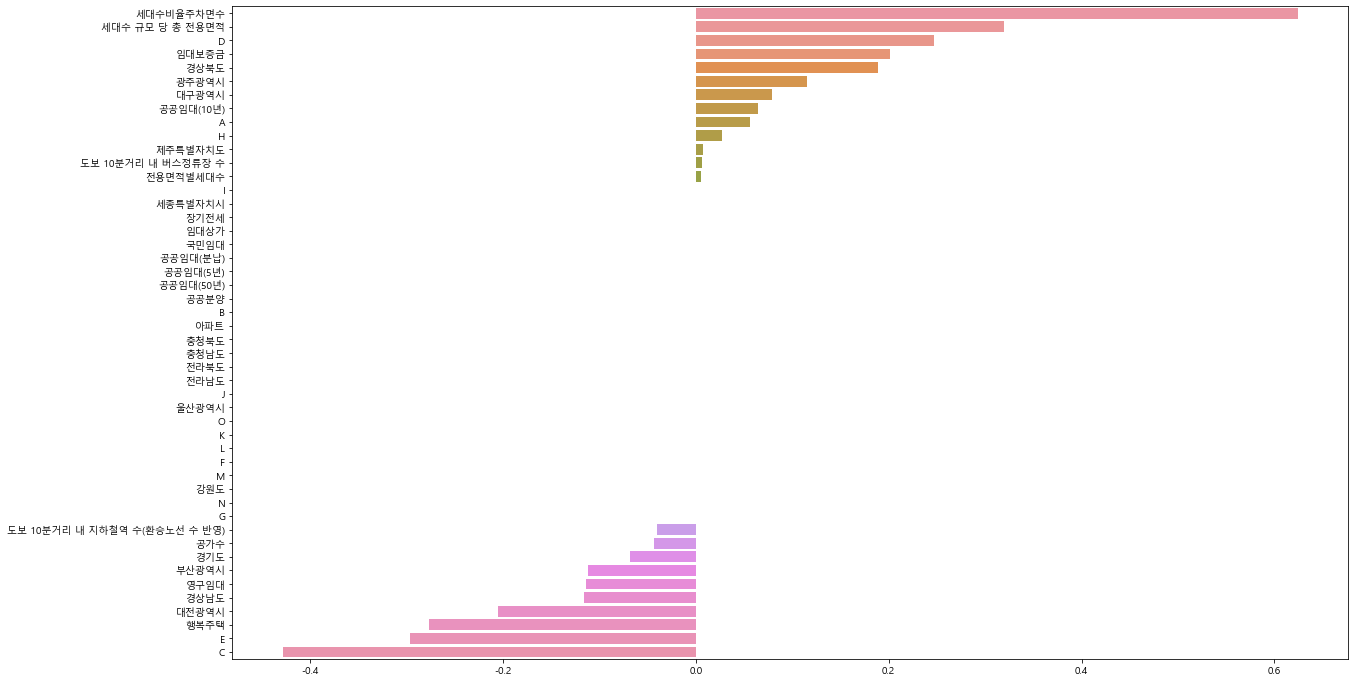

In [104]:
importance = lasso_grid.best_estimator_.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [105]:
lasso_best = lasso_grid.best_estimator_


X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = lasso_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.81494558419435

### Ridge & Lasso & CatBoost 조합 -> 0.2 & 0.2 & 0.6 조합

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

cat_reg = CatBoostRegressor(depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

# linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
# final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)


mean_absolute_error(np.expm1(y_test), np.expm1(cat_pred))

0:	learn: 1.6836479	total: 666us	remaining: 199ms
1:	learn: 1.5304107	total: 1.47ms	remaining: 220ms
2:	learn: 1.4016631	total: 2.14ms	remaining: 212ms
3:	learn: 1.2823412	total: 2.71ms	remaining: 201ms
4:	learn: 1.1715656	total: 3.31ms	remaining: 195ms
5:	learn: 1.0732556	total: 3.88ms	remaining: 190ms
6:	learn: 0.9862531	total: 4.45ms	remaining: 186ms
7:	learn: 0.9046749	total: 5ms	remaining: 183ms
8:	learn: 0.8335640	total: 5.55ms	remaining: 180ms
9:	learn: 0.7692056	total: 6.1ms	remaining: 177ms
10:	learn: 0.7143092	total: 6.67ms	remaining: 175ms
11:	learn: 0.6626233	total: 7.26ms	remaining: 174ms
12:	learn: 0.6192427	total: 7.82ms	remaining: 173ms
13:	learn: 0.5815990	total: 8.38ms	remaining: 171ms
14:	learn: 0.5456196	total: 8.95ms	remaining: 170ms
15:	learn: 0.5141816	total: 9.5ms	remaining: 169ms
16:	learn: 0.4847654	total: 10.1ms	remaining: 168ms
17:	learn: 0.4602011	total: 10.6ms	remaining: 167ms
18:	learn: 0.4375074	total: 11.2ms	remaining: 166ms
19:	learn: 0.4205472	total: 

258:	learn: 0.1869860	total: 147ms	remaining: 23.3ms
259:	learn: 0.1866536	total: 148ms	remaining: 22.8ms
260:	learn: 0.1864799	total: 149ms	remaining: 22.2ms
261:	learn: 0.1861593	total: 149ms	remaining: 21.6ms
262:	learn: 0.1859326	total: 150ms	remaining: 21.1ms
263:	learn: 0.1857540	total: 150ms	remaining: 20.5ms
264:	learn: 0.1855477	total: 151ms	remaining: 19.9ms
265:	learn: 0.1854246	total: 152ms	remaining: 19.4ms
266:	learn: 0.1852674	total: 152ms	remaining: 18.8ms
267:	learn: 0.1852158	total: 153ms	remaining: 18.2ms
268:	learn: 0.1851893	total: 153ms	remaining: 17.7ms
269:	learn: 0.1848099	total: 154ms	remaining: 17.1ms
270:	learn: 0.1845768	total: 154ms	remaining: 16.5ms
271:	learn: 0.1844836	total: 155ms	remaining: 16ms
272:	learn: 0.1842754	total: 156ms	remaining: 15.4ms
273:	learn: 0.1840961	total: 156ms	remaining: 14.8ms
274:	learn: 0.1839350	total: 157ms	remaining: 14.2ms
275:	learn: 0.1837206	total: 157ms	remaining: 13.7ms
276:	learn: 0.1834469	total: 158ms	remaining: 13

12.466423423340043

In [115]:
# ridge(0.2) lasso(0.2) catboost(0.6) 조합 -> 87.2708898934, MAE -> 10.8230

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.6)조합_공급유형추가_임대보증금예측값_캣부스트튜닝_0728.csv", index=False)

sub_df

0:	learn: 1.6869511	total: 728us	remaining: 218ms
1:	learn: 1.5455454	total: 1.54ms	remaining: 230ms
2:	learn: 1.4099566	total: 2.17ms	remaining: 214ms
3:	learn: 1.2945332	total: 2.79ms	remaining: 206ms
4:	learn: 1.1883772	total: 3.41ms	remaining: 201ms
5:	learn: 1.0923169	total: 4.03ms	remaining: 197ms
6:	learn: 1.0024976	total: 4.64ms	remaining: 194ms
7:	learn: 0.9264703	total: 5.31ms	remaining: 194ms
8:	learn: 0.8542971	total: 5.94ms	remaining: 192ms
9:	learn: 0.7943910	total: 6.57ms	remaining: 191ms
10:	learn: 0.7380474	total: 7.2ms	remaining: 189ms
11:	learn: 0.6879652	total: 7.84ms	remaining: 188ms
12:	learn: 0.6428859	total: 8.47ms	remaining: 187ms
13:	learn: 0.6005484	total: 9.11ms	remaining: 186ms
14:	learn: 0.5675032	total: 9.74ms	remaining: 185ms
15:	learn: 0.5337535	total: 10.4ms	remaining: 184ms
16:	learn: 0.5051956	total: 11ms	remaining: 183ms
17:	learn: 0.4818003	total: 11.6ms	remaining: 182ms
18:	learn: 0.4597180	total: 12.3ms	remaining: 182ms
19:	learn: 0.4397251	total

237:	learn: 0.2046626	total: 150ms	remaining: 39ms
238:	learn: 0.2045519	total: 150ms	remaining: 38.4ms
239:	learn: 0.2043890	total: 151ms	remaining: 37.8ms
240:	learn: 0.2043002	total: 152ms	remaining: 37.1ms
241:	learn: 0.2041590	total: 152ms	remaining: 36.5ms
242:	learn: 0.2040132	total: 153ms	remaining: 35.9ms
243:	learn: 0.2037904	total: 154ms	remaining: 35.3ms
244:	learn: 0.2035517	total: 154ms	remaining: 34.6ms
245:	learn: 0.2033326	total: 155ms	remaining: 34ms
246:	learn: 0.2029523	total: 156ms	remaining: 33.4ms
247:	learn: 0.2027199	total: 156ms	remaining: 32.7ms
248:	learn: 0.2025412	total: 157ms	remaining: 32.1ms
249:	learn: 0.2023919	total: 157ms	remaining: 31.5ms
250:	learn: 0.2022601	total: 158ms	remaining: 30.9ms
251:	learn: 0.2021065	total: 159ms	remaining: 30.2ms
252:	learn: 0.2019580	total: 159ms	remaining: 29.6ms
253:	learn: 0.2017904	total: 160ms	remaining: 29ms
254:	learn: 0.2017580	total: 161ms	remaining: 28.3ms
255:	learn: 0.2015565	total: 161ms	remaining: 27.7ms

,code,num
0,C1072,729.329066
1,C1128,1320.936772
2,C1456,558.046055
3,C1840,481.985105
4,C1332,1151.866077
...,...,...
145,C2456,242.430632
146,C1266,378.187190
147,C2152,26.456383
148,C1267,336.375237


In [108]:
# params = {'iterations': np.random.randint(100, 1000, size=10),
#           'depth': np.random.randint(1, 15, size=10),
#           'learning_rate': np.random.rand(10, 1).reshape(-1),
#           'l2_leaf_reg': np.random.randint(1, 30, size=5)}

# cat_reg = CatBoostRegressor(random_seed=42),
# grid_model = GridSearchCV(cat_reg, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
# grid_model.fit(X_train_df_log, y_train_df_log)

In [125]:
params = {'iterations': [300],
          'depth': [3],
          'learning_rate': [0.1],
          'l2_leaf_reg': [1]}

cat_reg = CatBoostRegressor(random_seed=42)
grid_model = GridSearchCV(cat_reg, param_grid=params, cv=3, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

0:	learn: 1.0223343	total: 749us	remaining: 224ms
1:	learn: 0.9427000	total: 1.81ms	remaining: 270ms
2:	learn: 0.8721652	total: 2.68ms	remaining: 266ms
3:	learn: 0.8082362	total: 3.38ms	remaining: 250ms
4:	learn: 0.7494112	total: 3.93ms	remaining: 232ms
5:	learn: 0.6964043	total: 4.52ms	remaining: 221ms
6:	learn: 0.6540206	total: 5.08ms	remaining: 213ms
7:	learn: 0.6142418	total: 5.71ms	remaining: 209ms
8:	learn: 0.5769832	total: 6.38ms	remaining: 206ms
9:	learn: 0.5431763	total: 7.04ms	remaining: 204ms
10:	learn: 0.5099753	total: 7.69ms	remaining: 202ms
11:	learn: 0.4853365	total: 8.26ms	remaining: 198ms
12:	learn: 0.4596350	total: 8.81ms	remaining: 195ms
13:	learn: 0.4387833	total: 9.35ms	remaining: 191ms
14:	learn: 0.4188415	total: 9.94ms	remaining: 189ms
15:	learn: 0.4004792	total: 10.6ms	remaining: 187ms
16:	learn: 0.3857137	total: 11.1ms	remaining: 185ms
17:	learn: 0.3712783	total: 11.7ms	remaining: 184ms
18:	learn: 0.3599131	total: 12.3ms	remaining: 181ms
19:	learn: 0.3494510	to

265:	learn: 0.1460688	total: 144ms	remaining: 18.4ms
266:	learn: 0.1458782	total: 144ms	remaining: 17.8ms
267:	learn: 0.1456129	total: 145ms	remaining: 17.3ms
268:	learn: 0.1454925	total: 145ms	remaining: 16.7ms
269:	learn: 0.1454114	total: 146ms	remaining: 16.2ms
270:	learn: 0.1452864	total: 146ms	remaining: 15.7ms
271:	learn: 0.1451571	total: 147ms	remaining: 15.1ms
272:	learn: 0.1450064	total: 147ms	remaining: 14.6ms
273:	learn: 0.1448530	total: 148ms	remaining: 14ms
274:	learn: 0.1447485	total: 148ms	remaining: 13.5ms
275:	learn: 0.1444686	total: 149ms	remaining: 13ms
276:	learn: 0.1441649	total: 149ms	remaining: 12.4ms
277:	learn: 0.1440314	total: 150ms	remaining: 11.9ms
278:	learn: 0.1438800	total: 151ms	remaining: 11.3ms
279:	learn: 0.1437460	total: 151ms	remaining: 10.8ms
280:	learn: 0.1436157	total: 152ms	remaining: 10.3ms
281:	learn: 0.1435427	total: 152ms	remaining: 9.71ms
282:	learn: 0.1432994	total: 153ms	remaining: 9.17ms
283:	learn: 0.1429217	total: 153ms	remaining: 8.63

179:	learn: 0.2176261	total: 95.2ms	remaining: 63.5ms
180:	learn: 0.2171746	total: 95.7ms	remaining: 62.9ms
181:	learn: 0.2170113	total: 96.3ms	remaining: 62.4ms
182:	learn: 0.2167336	total: 96.8ms	remaining: 61.9ms
183:	learn: 0.2165233	total: 97.4ms	remaining: 61.4ms
184:	learn: 0.2163086	total: 97.9ms	remaining: 60.9ms
185:	learn: 0.2157036	total: 98.5ms	remaining: 60.4ms
186:	learn: 0.2152027	total: 99.1ms	remaining: 59.9ms
187:	learn: 0.2151117	total: 99.6ms	remaining: 59.4ms
188:	learn: 0.2146319	total: 100ms	remaining: 58.8ms
189:	learn: 0.2142542	total: 101ms	remaining: 58.3ms
190:	learn: 0.2139912	total: 101ms	remaining: 57.8ms
191:	learn: 0.2135170	total: 102ms	remaining: 57.2ms
192:	learn: 0.2130532	total: 102ms	remaining: 56.7ms
193:	learn: 0.2124654	total: 103ms	remaining: 56.2ms
194:	learn: 0.2119430	total: 103ms	remaining: 55.7ms
195:	learn: 0.2115406	total: 104ms	remaining: 55.1ms
196:	learn: 0.2114368	total: 104ms	remaining: 54.6ms
197:	learn: 0.2108830	total: 105ms	re

81:	learn: 0.2431401	total: 47.6ms	remaining: 127ms
82:	learn: 0.2420183	total: 48.2ms	remaining: 126ms
83:	learn: 0.2414015	total: 48.9ms	remaining: 126ms
84:	learn: 0.2411439	total: 49.5ms	remaining: 125ms
85:	learn: 0.2408487	total: 50ms	remaining: 124ms
86:	learn: 0.2405577	total: 50.5ms	remaining: 124ms
87:	learn: 0.2401239	total: 51.1ms	remaining: 123ms
88:	learn: 0.2393422	total: 51.6ms	remaining: 122ms
89:	learn: 0.2387502	total: 52.1ms	remaining: 122ms
90:	learn: 0.2381675	total: 52.7ms	remaining: 121ms
91:	learn: 0.2378391	total: 53.2ms	remaining: 120ms
92:	learn: 0.2375486	total: 53.7ms	remaining: 120ms
93:	learn: 0.2370618	total: 54.4ms	remaining: 119ms
94:	learn: 0.2360820	total: 54.9ms	remaining: 118ms
95:	learn: 0.2355943	total: 55.5ms	remaining: 118ms
96:	learn: 0.2345927	total: 56ms	remaining: 117ms
97:	learn: 0.2341899	total: 56.5ms	remaining: 117ms
98:	learn: 0.2334139	total: 57.1ms	remaining: 116ms
99:	learn: 0.2330878	total: 57.6ms	remaining: 115ms
100:	learn: 0.23

1:	learn: 1.5392254	total: 1.91ms	remaining: 285ms
2:	learn: 1.4089712	total: 2.79ms	remaining: 277ms
3:	learn: 1.2884275	total: 3.62ms	remaining: 268ms
4:	learn: 1.1797889	total: 4.46ms	remaining: 263ms
5:	learn: 1.0801258	total: 5.28ms	remaining: 259ms
6:	learn: 0.9900522	total: 5.99ms	remaining: 251ms
7:	learn: 0.9139769	total: 6.64ms	remaining: 242ms
8:	learn: 0.8464138	total: 7.33ms	remaining: 237ms
9:	learn: 0.7822228	total: 7.98ms	remaining: 232ms
10:	learn: 0.7251621	total: 8.63ms	remaining: 227ms
11:	learn: 0.6758830	total: 9.28ms	remaining: 223ms
12:	learn: 0.6314933	total: 9.92ms	remaining: 219ms
13:	learn: 0.5927002	total: 10.6ms	remaining: 216ms
14:	learn: 0.5590064	total: 11.2ms	remaining: 212ms
15:	learn: 0.5275564	total: 11.8ms	remaining: 209ms
16:	learn: 0.5022055	total: 12.4ms	remaining: 207ms
17:	learn: 0.4779847	total: 13.1ms	remaining: 205ms
18:	learn: 0.4572254	total: 13.7ms	remaining: 203ms
19:	learn: 0.4368901	total: 14.4ms	remaining: 202ms
20:	learn: 0.4195537	

255:	learn: 0.2028141	total: 162ms	remaining: 27.9ms
256:	learn: 0.2025696	total: 163ms	remaining: 27.3ms
257:	learn: 0.2023281	total: 164ms	remaining: 26.7ms
258:	learn: 0.2020379	total: 164ms	remaining: 26ms
259:	learn: 0.2017908	total: 165ms	remaining: 25.4ms
260:	learn: 0.2015375	total: 166ms	remaining: 24.8ms
261:	learn: 0.2012806	total: 166ms	remaining: 24.1ms
262:	learn: 0.2011170	total: 167ms	remaining: 23.5ms
263:	learn: 0.2009119	total: 168ms	remaining: 22.9ms
264:	learn: 0.2007671	total: 168ms	remaining: 22.2ms
265:	learn: 0.2005636	total: 169ms	remaining: 21.6ms
266:	learn: 0.2003768	total: 170ms	remaining: 21ms
267:	learn: 0.1999648	total: 170ms	remaining: 20.3ms
268:	learn: 0.1997944	total: 171ms	remaining: 19.7ms
269:	learn: 0.1997182	total: 172ms	remaining: 19.1ms
270:	learn: 0.1995001	total: 172ms	remaining: 18.4ms
271:	learn: 0.1993887	total: 173ms	remaining: 17.8ms
272:	learn: 0.1991521	total: 173ms	remaining: 17.2ms
273:	learn: 0.1989846	total: 174ms	remaining: 16.5

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F203518640>,
             param_grid={'depth': [3], 'iterations': [300], 'l2_leaf_reg': [1],
                         'learning_rate': [0.1]},
             scoring='neg_mean_absolute_error')

In [126]:
grid_model.best_params_

{'depth': 3, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [127]:
cat_boost_best = grid_model.best_estimator_

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

cat_pred = cat_boost_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

10.731237926130666

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)


cat_pred = cat_boost_best.predict(X_test)

# linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
# final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)


mean_absolute_error(np.expm1(y_test), np.expm1(cat_pred))

12.303758103778572

In [132]:
# MAE 12.30

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_pred = cat_boost_best.predict(X_test_df_log)


linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.6)조합_공급유형추가_임대보증금예측값_그리드서치로셋팅_0728.csv", index=False)

sub_df

,code,num
0,C1072,713.583652
1,C1128,1282.909902
2,C1456,541.136889
3,C1840,481.227794
4,C1332,1163.918367
...,...,...
145,C2456,234.148595
146,C1266,393.804881
147,C2152,22.712002
148,C1267,316.472042


In [119]:
cat_reg = CatBoostRegressor(depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)
cat_pred = np.expm1(cat_pred)

# linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
# final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
# final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=cat_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
sub_df.to_csv("CatBoost1.0조합_공급유형추가_임대보증금예측값_캣부스트튜닝_0728.csv", index=False)

sub_df

0:	learn: 1.6869511	total: 725us	remaining: 217ms
1:	learn: 1.5455454	total: 1.52ms	remaining: 226ms
2:	learn: 1.4099566	total: 2.16ms	remaining: 214ms
3:	learn: 1.2945332	total: 2.88ms	remaining: 213ms
4:	learn: 1.1883772	total: 3.64ms	remaining: 215ms
5:	learn: 1.0923169	total: 4.37ms	remaining: 214ms
6:	learn: 1.0024976	total: 5.03ms	remaining: 211ms
7:	learn: 0.9264703	total: 5.65ms	remaining: 206ms
8:	learn: 0.8542971	total: 6.31ms	remaining: 204ms
9:	learn: 0.7943910	total: 7.01ms	remaining: 203ms
10:	learn: 0.7380474	total: 7.67ms	remaining: 202ms
11:	learn: 0.6879652	total: 8.36ms	remaining: 201ms
12:	learn: 0.6428859	total: 9.05ms	remaining: 200ms
13:	learn: 0.6005484	total: 9.69ms	remaining: 198ms
14:	learn: 0.5675032	total: 10.3ms	remaining: 196ms
15:	learn: 0.5337535	total: 11ms	remaining: 195ms
16:	learn: 0.5051956	total: 11.6ms	remaining: 194ms
17:	learn: 0.4818003	total: 12.3ms	remaining: 192ms
18:	learn: 0.4597180	total: 12.9ms	remaining: 191ms
19:	learn: 0.4397251	tota

250:	learn: 0.2022601	total: 159ms	remaining: 31.1ms
251:	learn: 0.2021065	total: 160ms	remaining: 30.5ms
252:	learn: 0.2019580	total: 161ms	remaining: 29.9ms
253:	learn: 0.2017904	total: 161ms	remaining: 29.2ms
254:	learn: 0.2017580	total: 162ms	remaining: 28.6ms
255:	learn: 0.2015565	total: 163ms	remaining: 28ms
256:	learn: 0.2014195	total: 163ms	remaining: 27.3ms
257:	learn: 0.2012803	total: 164ms	remaining: 26.7ms
258:	learn: 0.2010929	total: 165ms	remaining: 26.1ms
259:	learn: 0.2008592	total: 165ms	remaining: 25.4ms
260:	learn: 0.2006363	total: 166ms	remaining: 24.8ms
261:	learn: 0.2005038	total: 167ms	remaining: 24.2ms
262:	learn: 0.2003172	total: 167ms	remaining: 23.5ms
263:	learn: 0.2001647	total: 168ms	remaining: 22.9ms
264:	learn: 0.1998853	total: 169ms	remaining: 22.3ms
265:	learn: 0.1996056	total: 169ms	remaining: 21.6ms
266:	learn: 0.1994354	total: 170ms	remaining: 21ms
267:	learn: 0.1993962	total: 170ms	remaining: 20.4ms
268:	learn: 0.1991259	total: 171ms	remaining: 19.7

,code,num
0,C1072,751.549350
1,C1128,1414.849920
2,C1456,569.833894
3,C1840,476.027007
4,C1332,1163.564532
...,...,...
145,C2456,253.391834
146,C1266,351.661104
147,C2152,26.034262
148,C1267,342.907128
